# Assignment 2: Musical Note Classification

## Prerequisites


In [ ]:
# Call nvidia-smi to see if you have a GPU availble
!nvidia-smi

Wed Oct  2 19:21:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import sys
import json
import pathlib
import os
from os import path
import logging

import numpy as np
import matplotlib.pyplot as plt
import librosa
import tqdm
from IPython.display import display, Audio

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print(torch.__version__)

2.4.1+cu121


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dir = '/content/gdrive/My Drive/Academic Work/UM_PAT_PhD/classes/598 Music + AI (Dong)/assignment_2/data'
# processed_dir = data_dir / "processed"
processed_dir = data_dir
out_dir = '/content/gdrive/My Drive/Academic Work/UM_PAT_PhD/classes/598 Music + AI (Dong)/assignment_2/exp/baseline'

print(data_dir)

/content/gdrive/My Drive/Academic Work/UM_PAT_PhD/classes/598 Music + AI (Dong)/assignment_2/data


In [ ]:
# train_data_path = '/content/gdrive/My Drive/Academic Work/UM_PAT_PhD/classes/598 Music + AI (Dong)/assignment_2/data/train.zip'

# !unzip -u '/content/gdrive/My Drive/Academic Work/UM_PAT_PhD/classes/598 Music + AI (Dong)/assignment_2/data/train.zip' -d '/content/gdrive/My Drive/Academic Work/UM_PAT_PhD/classes/598 Music + AI (Dong)/assignment_2/data'

In [ ]:
# Make sure the output directory exists
# out_dir.mkdir(parents=True, exist_ok=True)

# if path.exists(out_dir) == False:
#    !mkdir out_dir

In [ ]:
# Set the sampling rate and the number of mel bins
sampling_rate = 8000
n_mels = 64

In [ ]:
class_names = ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "synth_lead", "vocal"]
n_classes = len(class_names)

In [ ]:
# Make sure the GPU is available -- training will be slow if you're not using a GPU
if torch.cuda.is_available():
    print("GPU available!")
else:
    print("\033[91m\033[1m Warning: GPU Unavailable!")

GPU available!


In [ ]:
# Initialize the device variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def load_json(filename):
    """Load a JSON file into a dictrionary."""
    with open(filename) as f:
        return json.load(f)

In [ ]:
def compute_melspec(filename):
    """Compute the mel spectrogram for an audio file."""
    # Load the audio file
    waveform, _ = librosa.load(filename, sr=sampling_rate)
    # Compute the mel spectrogram
    melspec = librosa.feature.melspectrogram(y=waveform, sr=sampling_rate, n_mels=n_mels, fmax=sampling_rate / 2)
    # Convert to decibel scale
    melspec = librosa.power_to_db(melspec, ref=np.max)
    return melspec

In [ ]:
def show_example(filename):
    """Compute and show the mel spectrogram for an audio file."""
    # Compute the mel spectrogram
    melspec = compute_melspec(filename)
    # Show the mel spectrogram
    img = librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=sampling_rate, fmax=sampling_rate / 2, auto_aspect=False)
    # Set the title to the filename
    plt.title(filename.stem)
    return melspec

## Inspecting the Dataset

In [ ]:
raw_dir = pathlib.Path("/nfs/turbo/smtd-hwdong/data/nsynth/nsynth-train").resolve()
wav_dir = raw_dir / "audio"

In [ ]:
# Load the metadata
examples = load_json(raw_dir / "examples.json")
keys = list(examples.keys())

In [ ]:
# The "examples.json" file use the filenames without extensions as the keys
keys[0]

'guitar_acoustic_001-082-050'

In [ ]:
# Show an example of the metadata provided in the "examples.json" file
examples[keys[0]]

{'note': 16629,
 'sample_rate': 16000,
 'pitch': 82,
 'instrument_source': 0,
 'instrument_family_str': 'guitar',
 'instrument_str': 'guitar_acoustic_001',
 'note_str': 'guitar_acoustic_001-082-050',
 'qualities_str': ['percussive'],
 'instrument_source_str': 'acoustic',
 'velocity': 50,
 'instrument_family': 3,
 'instrument': 39,
 'qualities': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]}

In [ ]:
# Visualize the mel spectrograms for the first several training samples
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    show_example(wav_dir / f"{keys[i]}.wav")
plt.subplots_adjust(wspace=.3, hspace=.4)
plt.show()

In [ ]:
# Show the corresponding WAV files
for i in range(6):
    display(Audio(filename=wav_dir / f"{keys[i]}.wav"))

## Build the Dataset

In [ ]:
# Define the Dataset class
class MelspecDataset(Dataset):
    """A dataset of precopmuted mel spectrograms."""
    def __init__(self, melspec_dir, meta_filename):
        # Initialize the parent object
        super().__init__()
        # Load the metadata into a dictionary
        metadata = load_json(meta_filename)
        # Find all the audio files
        print("Loading filenames...")
        self.filenames = [melspec_dir / f"{key}.npy" for key in metadata.keys()]
        # Find the corresponding labels
        print("Loading labels...")
        self.labels = []
        for filename in tqdm.tqdm(self.filenames):
            self.labels.append(metadata[filename.stem]["instrument_family"])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load the mel spectrogram
        try:
            melspec = np.load(self.filenames[idx])
        except Exception as e:
            print(self.filenames[idx])
            raise e
        return melspec, self.labels[idx]

In [ ]:
# Define the Dataset class
class PreloadedMelspecDataset(Dataset):
    """A dataset of precopmuted mel spectrograms."""
    def __init__(self, melspec_dir, meta_filename):
        # Initialize the parent object
        super().__init__()
        # Load the metadata into a dictionary
        metadata = load_json(meta_filename)
        # Find all the audio files
        print("Loading filenames...")
        self.filenames = [melspec_dir / f"{key}.npy" for key in metadata.keys()]
        # Load the mel spectrograms
        print("Loading mel spectrograms...")
        self.melspecs = [np.load(filename) for filename in tqdm.tqdm(self.filenames) if os.path.exists(filename) and os.path.getsize(filename) > 0]
        # Find the corresponding labels
        print("Loading labels...")
        self.labels = [metadata[filename.stem]["instrument_family"] for filename in tqdm.tqdm(self.filenames)]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        return self.melspecs[idx], self.labels[idx]

In [19]:
# Count melspec files
print(len(os.listdir('/content/gdrive/My Drive/Academic Work/UM_PAT_PhD/classes/598 Music + AI (Dong)/assignment_2/data/train/train/melspec')))

46203


In [ ]:
# Initialize the train, validation and test dataset objects
# train_dataset = PreloadedMelspecDataset(pathlib.Path(processed_dir) / "train" / "train" / "melspec", pathlib.Path(processed_dir) / "train" / "train" / "examples.json")
# valid_dataset = PreloadedMelspecDataset(pathlib.Path(processed_dir) / "valid" / "melspec", pathlib.Path(processed_dir) / "valid" / "examples.json")

# Use the following instead if you don't have large enough RAM available
train_dataset = MelspecDataset(pathlib.Path(processed_dir) / "train" / "train" / "melspec", pathlib.Path(processed_dir) / "train" / "train" / "examples.json")
valid_dataset = MelspecDataset(pathlib.Path(processed_dir) / "valid" / "melspec", pathlib.Path(processed_dir) / "valid" / "examples.json")

Loading filenames...
Loading labels...


100%|██████████| 289205/289205 [00:00<00:00, 629868.02it/s]


Loading filenames...
Loading labels...


100%|██████████| 12678/12678 [00:00<00:00, 732978.43it/s]


/content/gdrive/My Drive/Academic Work/UM_PAT_PhD/classes/598 Music + AI (Dong)/assignment_2/data/train/train/melspec/vocal_synthetic_012-086-100.npy


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/Academic Work/UM_PAT_PhD/classes/598 Music + AI (Dong)/assignment_2/data/train/train/melspec/vocal_synthetic_012-086-100.npy'

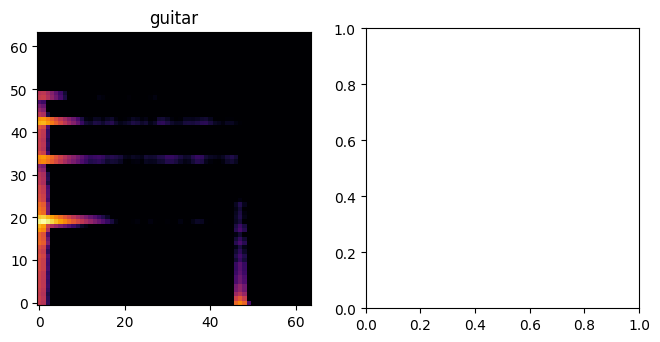

In [ ]:
# Show some examples of the training set
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    melspec, label = train_dataset[i * 10]
    plt.imshow(melspec[0], cmap="inferno", origin="lower", aspect="equal")
    plt.title(class_names[label])
plt.subplots_adjust(wspace=.3, hspace=.4)
plt.show()

## Build the Convolutional Neural Network (CNN)

In [ ]:
class CNN(nn.Module):
    """A basic convolutional neural network."""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding="same")
        self.conv2 = nn.Conv2d(16, 32, 3, padding="same")
        self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
        self.conv4 = nn.Conv2d(64, 128, 3, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 4 * 4, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
# Create the model
model = CNN()

# Move the model to GPU
model = model.to(device)

In [ ]:
# Show the number of parameters in the model
print(sum(param.numel() for param in model.parameters()))

119691


## Train the Neural Network

In [ ]:
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Initialize the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# Create the data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)

In [ ]:
# Set up the checkpoint directory
checkpoint_dir = out_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Start the training
n_epochs = 20
step = 0
train_losses, valid_losses = [], []
min_val_loss = float("inf")
for epoch in range(n_epochs):

    # Training loop
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch}")
    for i, (melspecs, labels) in enumerate(pbar):
        # Move the data to GPU
        melspecs = melspecs.to(device)
        labels = labels.to(device)

        # Set the model to training mode
        model.train()

        # Clear the gradients
        optimizer.zero_grad()

        # Pass the inputs through the neural network
        prediction = model(melspecs)

        # Compute the loss
        loss = criterion(prediction, labels)
        train_losses.append(float(loss))

        # Backpropagate the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Show the current training loss on the progress bar
        pbar.set_postfix(loss=float(loss))

        # Increment the step counter
        step += 1

    # Save a checkpoint
    torch.save(model.state_dict(), checkpoint_dir / f"model_epoch_{epoch}.pt")

    # Save the training losses
    np.save(out_dir / "train_losses.npy", train_losses)

    # Validation loop
    val_loss = 0
    count_correct = 0
    pbar = tqdm.tqdm(valid_loader, desc=f"Validation:")
    for i, (melspecs, labels) in enumerate(pbar):
        # Move the data to GPU
        melspecs = melspecs.to(device)
        labels = labels.to(device)

        # Set the model to evaluation mode
        model.eval()

        # Pass the inputs through the neural network
        prediction = model(melspecs)

        # Compute the loss
        loss = criterion(prediction, labels)

        # Accumulate the loss
        val_loss += len(melspecs) * float(loss)

        # Accumulate the counter for correct predictions
        count_correct += torch.count_nonzero(prediction.argmax(1) == labels)

    # Compute the validation loss
    val_loss = val_loss / len(valid_dataset)
    valid_losses.append(val_loss)
    print(f"Validation loss: {val_loss}")

    # Save the validation losses
    np.save(out_dir / "valid_losses.npy", valid_losses)

    # Compute the validation accuracy
    val_acc = count_correct / len(valid_dataset)
    print(f"Validation accuracy: {val_acc}")

    # Save minimum validation loss
    if val_loss < min_val_loss:
        # Save the best model
        torch.save(model.state_dict(), checkpoint_dir / f"best_model.pt")
        # Update the minimum validation loss so far
        min_val_loss = val_loss

Validation:: 100%|██████████| 397/397 [00:01<00:00, 207.27it/s]


Validation loss: 1.7566448752672106
Validation accuracy: 0.38042277097702026


Validation:: 100%|██████████| 397/397 [00:02<00:00, 198.06it/s]


Validation loss: 1.5727118516611478
Validation accuracy: 0.4710521996021271


Validation:: 100%|██████████| 397/397 [00:01<00:00, 208.86it/s]


Validation loss: 1.4374354191713292
Validation accuracy: 0.5217700004577637


Validation:: 100%|██████████| 397/397 [00:02<00:00, 188.96it/s]


Validation loss: 1.4544141821482144
Validation accuracy: 0.5668086409568787


Validation:: 100%|██████████| 397/397 [00:01<00:00, 210.15it/s]


Validation loss: 1.3563505048386248
Validation accuracy: 0.6199715733528137


Validation:: 100%|██████████| 397/397 [00:01<00:00, 208.54it/s]


Validation loss: 1.4256604067495822
Validation accuracy: 0.6202871203422546


Validation:: 100%|██████████| 397/397 [00:01<00:00, 208.51it/s]


Validation loss: 1.3309796756140195
Validation accuracy: 0.6446600556373596


Validation:: 100%|██████████| 397/397 [00:02<00:00, 185.99it/s]


Validation loss: 1.4668307579133502
Validation accuracy: 0.6455276608467102


Validation:: 100%|██████████| 397/397 [00:01<00:00, 210.83it/s]


Validation loss: 1.5166098109779533
Validation accuracy: 0.6449755430221558


Epoch 9:  97%|█████████▋| 8727/9038 [00:28<00:00, 347.02it/s, loss=0.843]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Validation:: 100%|██████████| 397/397 [00:01<00:00, 209.84it/s]


Validation loss: 1.533533281370901
Validation accuracy: 0.6799968481063843


Validation:: 100%|██████████| 397/397 [00:01<00:00, 198.81it/s]


Validation loss: 1.5364666984441961
Validation accuracy: 0.694352388381958


Validation:: 100%|██████████| 397/397 [00:01<00:00, 207.45it/s]loss=0.131] 


Validation loss: 1.533155231713534
Validation accuracy: 0.6864647269248962


Epoch 17:  32%|███▏      | 2883/9038 [00:10<00:18, 331.37it/s, loss=0.447]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# Compute the moving average of the training loss for better visualization
w = 100
train_losses_moving_average = np.convolve(train_losses, np.ones(w), "valid") / w

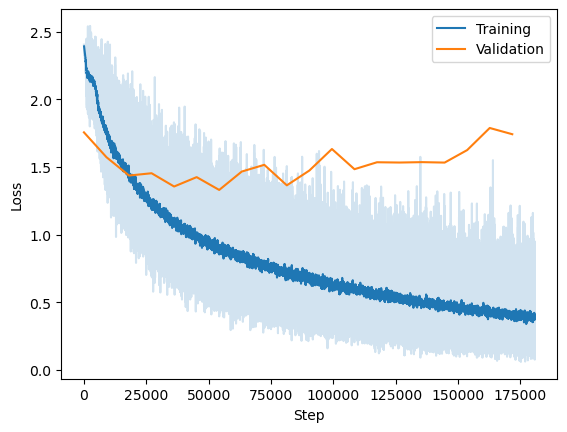

In [ ]:
# Show the training and validation loss curves
plt.plot(np.arange(len(train_losses)), train_losses, color="C0", alpha=0.2)
plt.plot(np.arange(len(train_losses_moving_average)) + w / 2, train_losses_moving_average, label="Training", color="C0")
plt.plot(np.arange(len(valid_losses)) * (len(train_dataset) // batch_size), valid_losses, label="Validation", color="C1")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Test the Neural Network

In [ ]:
# Load the best model back
model.load_state_dict(torch.load(checkpoint_dir / f"best_model.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
test_dataset = MelspecDataset(processed_dir / "test" / "melspec", processed_dir / "test" / "examples.json")
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

Loading filenames...
Loading labels...


100%|██████████| 4096/4096 [00:00<00:00, 1420763.25it/s]


In [ ]:
# Test loop
test_loss = 0
count_correct = 0
pbar = tqdm.tqdm(test_loader, desc=f"Test:")
for i, (melspecs, labels) in enumerate(pbar):
    # Move the data to GPU
    melspecs = melspecs.to(device)
    labels = labels.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Pass the inputs through the neural network
    prediction = model(melspecs)

    # Compute the loss
    loss = criterion(prediction, labels)

    # Accumulate the loss
    test_loss += len(melspec) * float(loss)

    # Accumulate the counter for correct predictions
    count_correct += torch.count_nonzero(prediction.argmax(1) == labels)

test_loss = test_loss / len(test_dataset)
test_acc = count_correct / len(test_dataset)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

Test:: 100%|██████████| 128/128 [00:02<00:00, 50.70it/s]

Test loss: 0.04260024768882431
Test accuracy: 0.647216796875
